# SysArmy - Análisis de encuesta 2020.02

## 1. Carga y sanitización de datos

###  1.1. Definimos los metadatos asociados al dataset que vamos a analizar

In [1]:
%load_ext nb_black

csv_url = "https://raw.githubusercontent.com/openqube/openqube-sueldos/release/2020.02/data/csv/argentina/2020.02.csv"

dataset_metadata = {
    "year": 2020,
    "part": 2,
    "skiprows": 0,
    "publish_date": "2020-08-15",
    "minimum_salary": 16875,  # https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina
}

<IPython.core.display.Javascript object>

### 1.2. En base a los metadatos, cargamos el CSV, limpiamos columnas y las transformamos

In [2]:
import pandas as pd
import io
import requests
from time import sleep

raw_dataframe = None
source = requests.get(
    csv_url.format(dataset_metadata["year"], dataset_metadata["part"])
).content
raw_dataframe = pd.read_csv(
    io.StringIO(source.decode("utf-8")),
    skiprows=dataset_metadata["skiprows"],
    thousands=".",
    decimal=",",
)

# resultados que no pertenezcan a Argentina quedan fuera de este análisis
columns_to_remove = [
    "Bolivia",
    "Chile",
    "Colombia",
    "Cuba",
    "Costa Rica",
    "Ecuador",
    "El Salvador",
    "Guatemala",
    "Honduras",
    "México",
    "Nicaragua",
    "Panamá",
    "Paraguay",
    "Perú",
    "Puerto Rico",
    "República Dominicana",
    "Uruguay",
    "Venezuela",
]

raw_dataframe.drop(columns_to_remove, axis=1, inplace=True)

import re

regex_white_chars = re.compile(r"\s+")
regex_non_alphanum = re.compile(r"\W+_?", re.I)

raw_dataframe.columns = (
    raw_dataframe.columns.str.strip()
    .str.lower()
    .str.replace(regex_white_chars, "_")
    .str.replace(regex_non_alphanum, "")
    .str.translate(
        "ñáéíóú".maketrans({"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"})
    )
)

dataframe = raw_dataframe.copy()

display([column for column in dataframe.columns])

['timestamp',
 'me_identifico',
 'tengo',
 'estoy_trabajando_en',
 'donde_estas_trabajando',
 'anos_de_experiencia',
 'anos_en_la_empresa_actual',
 'anos_en_el_puesto_actual',
 'gente_a_cargo',
 'nivel_de_estudios_alcanzado',
 'estado',
 'carrera',
 'universidad',
 'realizaste_cursos_de_especializacion',
 'contribuis_a_proyectos_open_source',
 'programas_como_hobbie',
 'trabajo_de',
 'plataformas',
 'lenguajes_de_programacion',
 'frameworksherramientas_y_librerias',
 'bases_de_datos',
 'qa_testing',
 'ides',
 'que_so_usas_en_tu_laptoppc_para_trabajar',
 'y_en_tu_celular',
 'tenes_guardias',
 'cuanto_cobras_por_guardia',
 'porcentajebruto_o_neto',
 'tipo_de_contrato',
 'salario_mensual_bruto_en_tu_moneda_local',
 'salario_mensual_neto_en_tu_moneda_local',
 'unnamed49',
 'que_tan_conforme_estas_con_tu_sueldo',
 'como_crees_que_esta_tu_sueldo_con_respecto_al_ultimo_semestre',
 'recibis_algun_tipo_de_bono',
 'a_que_esta_atado_el_bono',
 'tuviste_ajustes_por_inflacion_en_lo_que_va_de_2020',

<IPython.core.display.Javascript object>

### 1.3. Echamos un vistazo al dataframe previo a sanitizarlo

In [3]:
raw_dataframe.T.head()

,0,1,2,3,4,5,6,7,8,9,...,6405,6406,6407,6408,6409,6410,6411,6412,6413,6414
timestamp,7/6/2020 9:56:02,7/6/2020 9:57:09,7/6/2020 9:58:09,7/6/2020 9:59:52,7/6/2020 10:01:27,7/6/2020 10:03:13,7/6/2020 10:04:00,7/6/2020 10:04:01,7/6/2020 10:05:13,7/6/2020 10:07:13,...,8/15/2020 17:12:47,8/15/2020 17:13:01,8/15/2020 17:18:17,8/15/2020 17:21:22,8/15/2020 17:32:12,8/15/2020 22:04:58,8/15/2020 22:48:40,8/15/2020 23:54:10,8/16/2020 0:45:57,8/16/2020 1:03:20
me_identifico,Mujer,Hombre,Mujer,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Otros,...,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre,Hombre
tengo,26,29,22,39,32,25,33,23,40,35,...,34,52,43,32,32,37,38,24,28,33
estoy_trabajando_en,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,...,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina
donde_estas_trabajando,Ciudad Autónoma de Buenos Aires,Corrientes,Ciudad Autónoma de Buenos Aires,Corrientes,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Provincia de Buenos Aires,Entre Ríos,Ciudad Autónoma de Buenos Aires,...,Ciudad Autónoma de Buenos Aires,Santa Fe,Ciudad Autónoma de Buenos Aires,Provincia de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,La Pampa,GBA


<IPython.core.display.Javascript object>

### 1.4. Sanitizamos/normalizamos datos que encontramos mal formados o repetidos

In [4]:
import re


def normalize_dataframe_column(df_in, column_name, regex_assign_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        df_out.loc[mask, column_name] = value

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out


def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, pattern in regex_replace_map.items():
        compiled_regex = re.compile(regex, re.I)
        df_out[column_name] = (
            df_out[column_name].str.strip().str.replace(compiled_regex, pattern)
        )

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out

<IPython.core.display.Javascript object>

#### 1.4.1. Carreras

In [5]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "carrera",
    {
        "(Derecho|Abogac[íi]a|abogad.)": "Derecho",
        "(Contador.*)": "Contador Público",
        "(Arquitect(o|a|ura))": "Arquitectura",
        "(Lic.*)?Psicolog[íi]a": "Licenciatura en Psicología",
        "(Lic.*)?Marketing": "Licenciatura en Marketing",
        ".*Comunicación": "Licenciatura en Comunicación",
        "Letras": "Licenciatura en Letras",
        "Tec.*Infraestructuras{0,2}": "Tecnicatura Superior en Soporte de Infraestructuras",
        "(lic.*qu[ií]mica)": "Licenciatura en Química",
        "^(RRHH|Trabajo)": "Licenciatura en Relaciones del Trabajo",
        "(Lic.*)?Administraci[oó]n( de empresas)?": "Licenciatura en Administración de Empresas",
        "Ed.*f[ií]sica": "Educación Física",
        "Licenciatura en Cienciasdela Computación": "Licenciatura en Ciencias de la Computación",
        "Licenciatura en Ciencias dela Computación": "Licenciatura en Ciencias de la Computación",
        "(ningun(a|o)|-)": "DELETEME",
        "Lic.* Matemáticas?": "Licenciatura en Matemática",
        "(lic.*)econom[íi]a": "Licenciatura en Economía",
        "ingenier[íi]a de sistemas": "Ingeniería en Sistemas",
        "^(.*)\.$": "\\1",
    },
)

df = dataframe["carrera"].value_counts(sort=True)
display(df[:55])

'reduced in 0.128846'

Ingeniería en Sistemas de Información             1265
Ingeniería en Informática                          825
Analista de Sistemas                               606
Licenciatura en Ciencias de la Computación         308
Licenciatura en Sistemas de Información            303
Licenciatura en Informática                        275
Tecnicatura en Programación                        192
Ingeniería Electrónica                             161
Ingeniería en Computación                          147
Diseño Gráfico                                     142
Tecnicatura Superior en Programación               135
Licenciatura en Análisis de Sistemas               108
Tecnicatura en Informática                         101
Licenciatura en Administración de Empresas          90
Analista Programador                                87
Ingeniería en Telecomunicaciones                    77
Tecnicatura Superior en Sistemas Informáticos       74
Analista Programador Universitario                  69
Ingeniería

<IPython.core.display.Javascript object>

#### 1.4.2. Universidades

In [6]:
# En Mendoza se asocia UM a la Universidad de Mendoza, y en Buenos Aires, a la Universidad de Morón
mask = dataframe.eval(
    'universidad in ["UM", "Um"] and donde_estas_trabajando == "Mendoza"'
)
dataframe.universidad.loc[mask] = "Universidad Nacional de Mendoza"
display(dataframe[mask].universidad)

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


4066    Universidad Nacional de Mendoza
Name: universidad, dtype: object

<IPython.core.display.Javascript object>

In [7]:
dataframe = normalize_dataframe_column(
    dataframe,
    "universidad",
    {
        "(UNSJ|.*Nacional de San Juan)": "UNSJ - Universidad Nacional de San Juan",
        "IRSO": "IRSO - Instituto Raúl Scalabrini Ortíz",
        "(UNPSJB|.*Patagonia San Juan Bosco.*)": "UNPSJB - Universidad Nacional de la Patagonia San Juan Bosco",
        "(UNSL|Universidad Nacional de San Luis)": "UNSL - Universidad Nacional de San Luis",
        "IFTS18": "IFTS18 - Instituto de Formación Técnica Superior N°18",
        "UCASAL": "UCASAL - Universidad Católica de Salta",
        "Universidad de Mendoza": "UM - Universidad de Mendoza",
        "UNTREF": "UNTREF - Universidad Nacional de Tres de Febrero",
        "(UNL[uU]|Universidad Nacional de Luj[aá]n)": "UNLu - Universidad Nacional de Luján",
        "(UAA|.*Atl[aá]ntida.*)": "UAA - Universidad Atlántida Argentina",
        "([fF]?IUPFA)": "IUPFA - Instituto Universitario de la Policía Federal Argentina",
        "([uU]?FASTA)": "FASTA - Fraternidad de Agrupaciones Santo Tomás de Aquino",
        "(UCSE)": "UCSE - Universidad Católica de Santiago del Estero",
        "(ISIV|.*Virasoro.*)": "ISIV - Instituto Superior de Informática Virasoro",
        "(UN[Aa]M)": "UNaM - Universidad Nacional de Misiones",
        "(-|ninguna)$": "DELETEME",
    },
)

df = dataframe["universidad"].value_counts(sort=True)
display(df[:60])

'reduced in 0.065494'

UTN - Universidad Tecnológica Nacional                                        1387
UBA - Universidad de Buenos Aires                                              788
UNLaM - Universidad Nacional de La Matanza                                     236
UADE - Universidad Argentina De la Empresa                                     205
UAI - Universidad Abierta Interamericana                                       193
UNLP - Universidad Nacional de La Plata                                        185
ORT                                                                            130
UP - Universidad de Palermo                                                    110
Universidad Siglo 21                                                           104
UNC - Universidad Nacional de Córdoba                                           95
UCAECE - Centro de Altos Estudios en Ciencias Exactas                           70
UNICEN - Universidad Nacional del Centro de la Provincia de Buenos Aires        68
Escu

<IPython.core.display.Javascript object>

#### 1.4.3. Experiencia

In [8]:
dataframe["anos_de_experiencia"] = dataframe["anos_de_experiencia"].astype(int)
dataframe["anos_en_la_empresa_actual"] = dataframe["anos_en_la_empresa_actual"].astype(
    int
)
dataframe["anos_en_el_puesto_actual"] = dataframe["anos_en_el_puesto_actual"].astype(
    int
)

<IPython.core.display.Javascript object>

#### 1.4.4. Regiones

In [9]:
dataframe = normalize_dataframe_column(
    dataframe,
    "donde_estas_trabajando",
    {"(GBA|Provincia de Buenos Aires)": "Buenos Aires",},
)

display(dataframe["donde_estas_trabajando"].unique())

'reduced in 0.038462'

array(['Ciudad Autónoma de Buenos Aires', 'Corrientes', 'Buenos Aires',
       'Entre Ríos', 'Córdoba', 'Tucumán', 'Santa Fe', 'Neuquén', nan,
       'Mendoza', 'Misiones', 'Chaco', 'Chubut', 'Jujuy', 'La Rioja',
       'Río Negro', 'Salta', 'Tierra del Fuego', 'San Luis', 'Catamarca',
       'San Juan', 'Santiago del Estero', 'La Pampa', 'Formosa',
       'Santa Cruz'], dtype=object)

<IPython.core.display.Javascript object>

#### 1.4.5. Discapacidad

In [10]:
dataframe = normalize_dataframe_column(
    dataframe,
    "tenes_algun_tipo_de_discapacidad",
    {
        "^(_|-|no( tengo)?|ningun[oa]|nada|0|ni)$": None,
        ".*auditiv[oa].*": "Auditiva",
        ".*visual.*": "Visual",
        "mental": "Mental",
        "motriz": "Motriz",
        "vis?ceral": "Visceral",
        "^(sobrepeso|obesidad)": "Obesidad",
    },
)

df = dataframe["tenes_algun_tipo_de_discapacidad"].value_counts(sort=True)
display(df[:6])

'reduced in 0.340206'

Visual      376
Auditiva     41
Motriz       19
Mental       14
Visceral      5
Obesidad      4
Name: tenes_algun_tipo_de_discapacidad, dtype: int64

<IPython.core.display.Javascript object>

#### 1.4.5. Roles

In [11]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "trabajo_de",
    {
        "Project Manager.*": "Project Manager",
        "Director, Product Manager, Project Manager": "Manager / Director",
        "Technical Leader.*": "Technical Leader",
        "Team Leader.*": "Technical Leader",
        "Full ?Stack Developer": "Developer",
        "Seguridad Inform[aá]tica": "Infosec",
        "(profesor|instructor|educador|docente|capacitador.*)": "Docente",
        "^(Soporte T[ée]cnico|Technical support|Support)": "Technical Support",
        "Software Engineer": "Developer",
        "(Analista )?programador": "Developer",
        "Analista Funcional": "Functional Analyst",
        "Technical Functional Analyst": "Functional Analyst",
        "administrativo": "Administrativo",
        "^cto.*": "CTO",
        "Asistant": "Assistant",
        "helpdesk": "HelpDesk",
        "(Analista de seguridad|Security.*)": "Infosec",
        "BI Leader": "BI Analyst / Data Analyst",
    },
)

df = dataframe["trabajo_de"].value_counts(sort=True)
display(df[0:50])

'reduced in 0.072674'

Developer                         2501
SysAdmin / DevOps / SRE            740
Technical Leader                   420
QA / Tester                        262
Manager / Director                 250
HelpDesk                           230
Project Manager                    200
Architect                          181
Consultant                         155
Networking                         151
Data Scientist / Data Engineer     146
BI Analyst / Data Analyst          140
Business Analyst                   113
Infosec                             99
UX                                  96
DBA                                 59
Designer                            56
Recruiter / HR                      55
Product Manager                     51
Scrum Master                        50
VP / C-Level                        39
Sales / Pre-Sales                   29
Middleware                          24
Finance                             14
Functional Analyst                  11
Storage / Backup         

<IPython.core.display.Javascript object>

#### 1.4.6. Salario (corrección de numeración)

In [12]:
# Algunos salarios están cargados, pareciera ser, en miles

<IPython.core.display.Javascript object>

#### 1.4.7. Sueldo dolarizado

In [13]:
mask = dataframe["beneficios_extra"].str.contains("Sueldo dolarizado", na=False)
column_name = "sueldo_dolarizado"

dataframe.loc[~mask, column_name] = False
dataframe.loc[mask, column_name] = True
# display(dataframe['sueldo_dolarizado'])

<IPython.core.display.Javascript object>

### 1.5. Agregamos columnas calculadas

In [14]:
dataframe["seniority"] = pd.cut(
    dataframe["anos_de_experiencia"].values,
    [0, 2, 5, 50],
    labels=["Junior", "Semi-Senior", "Senior"],
)
display(dataframe["seniority"])

0       Semi-Senior
1       Semi-Senior
2            Junior
3            Senior
4            Senior
           ...     
6410         Senior
6411         Senior
6412         Junior
6413    Semi-Senior
6414    Semi-Senior
Name: seniority, Length: 6415, dtype: category
Categories (3, object): ['Junior' < 'Semi-Senior' < 'Senior']

<IPython.core.display.Javascript object>

### 1.6. Eliminamos outliers

In [15]:
salary_debug_columns = [
    "tengo",
    "anos_de_experiencia",
    "estoy_trabajando_en",
    "tipo_de_contrato",
    "salario_mensual_bruto_en_tu_moneda_local",
]


def remove_outlier(df_in, col_name, iqr_factor=1.5):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

<IPython.core.display.Javascript object>

#### 1.6.1. Salarios

In [16]:
df_inliers, df_outliers = remove_outlier(
    dataframe, "salario_mensual_bruto_en_tu_moneda_local", 3.5
)

# inliers percent over total
display(len(df_inliers) / len(dataframe))

# display outliers
display(df_outliers[salary_debug_columns])

0.9557287607170694

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_bruto_en_tu_moneda_local
61,50,30,Argentina,Full-Time,480000
64,41,20,Chile,Full-Time,1967856
81,29,5,Argentina,Full-Time,6024096
206,30,7,Argentina,Full-Time,1243872
232,23,0,Argentina,Full-Time,4298125
...,...,...,...,...,...
6321,37,14,Paraguay,Full-Time,8000000
6322,37,14,Paraguay,Full-Time,8000000
6377,22,1,Paraguay,Freelance,2000000
6396,45,15,Venezuela,Full-Time,40000000


<IPython.core.display.Javascript object>

In [17]:
minimum_salary = dataset_metadata["minimum_salary"]
df_outliers_lower_limit = df_inliers.query(
    "salario_mensual_bruto_en_tu_moneda_local < @minimum_salary/2.0"
)
display(len(df_outliers_lower_limit))
display(df_outliers_lower_limit[salary_debug_columns])
df_inliers_lower_limit = df_inliers.query(
    "salario_mensual_bruto_en_tu_moneda_local >= @minimum_salary/2.0"
)

dataframe = df_inliers_lower_limit

235

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_bruto_en_tu_moneda_local
153,34,8,Argentina,Full-Time,55
160,34,6,Argentina,Full-Time,6300
168,26,2,Argentina,Full-Time,75
203,25,2,Argentina,Full-Time,85
226,32,15,Argentina,Full-Time,187
...,...,...,...,...,...
6274,27,5,Argentina,Full-Time,107
6281,25,2,Perú,Full-Time,2500
6298,29,6,Argentina,Remoto (empresa de otro país),1000
6318,26,2,Perú,Full-Time,1500


<IPython.core.display.Javascript object>

### 1.7 Helper functions

In [18]:
def invert_non_representative_values(
    dataframe,
    column,
    representative_values,
    value_column="salario_mensual_bruto_en_tu_moneda_local",
):
    df.loc[
        df.eval("{} not in @representative_values".format(column)), value_column
    ] *= -1
    return df


def filter_valid_top_values(
    dataframe,
    column,
    top_values,
    value_column="salario_mensual_bruto_en_tu_moneda_local",
):
    return dataframe.query(
        '{} in @top_values & {} != "DELETEME"'.format(column, column)
    )


def get_two_dimensional_median_with_outliers_filtered(
    dataframe, group_by_columns, value_column="salario_mensual_bruto_en_tu_moneda_local"
):
    """
  Given a dataframe, groups data by the first given column in group_by_columns, computes median
  and sets to zero all values that have less than 5% of representation on the second column
  """
    dfl = (
        dataframe.groupby(group_by_columns)
        .size()
        .to_frame()
        .groupby(level=0)
        .apply(lambda x: x / float(x.sum()))
        .rename(columns={0: "population"})
        .query("population > 0.05")
        .drop(columns=["population"])
        .reset_index()
    )
    dfr = (
        dataframe.groupby(group_by_columns)
        .median()[value_column]
        .fillna(0)
        .to_frame()
        .reset_index()
    )
    return (
        pd.merge(dfl, dfr, on=group_by_columns, how="inner")
        .groupby(group_by_columns)
        .min()
        .unstack(group_by_columns[1])[value_column]
        .fillna(0)
    )

<IPython.core.display.Javascript object>

## 2. Análisis de resultados

Análisis exploratorio de los datos, los resultados se exportan en un JSON llamado 'charts'

In [19]:
charts = {
    "total_surveyed": len(raw_dataframe),
    "total_analyzed_surveyed": len(dataframe),
}

display(charts)


def to_rechart(df, max=0):
    """
  if max is set, groups the exceeded rows into 'Otros' column, summing values
  """
    if max != 0:
        # df = df.sort_values(by, ascending=False)
        others = df[max:].sum()
        df = df[:max]
        df.loc["Otros"] = others
    return {
        "data": [
            {"name": str(name), **(data if isinstance(data, dict) else {"value": data})}
            for name, data in df.T.to_dict().items()
        ],
    }

{'total_surveyed': 6415, 'total_analyzed_surveyed': 5896}

<IPython.core.display.Javascript object>

### 2.1. Perfiles

#### 2.1.1. Regiones

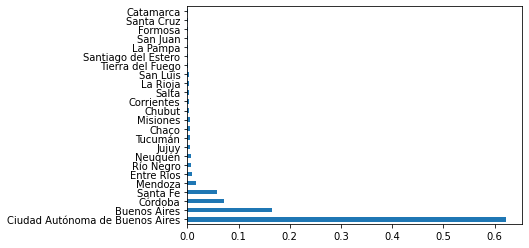

<IPython.core.display.Javascript object>

In [20]:
df = dataframe["donde_estas_trabajando"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["regions_percent"] = to_rechart(df)

#### 2.1.2. Roles (Posición, Open Source, Hobbie)

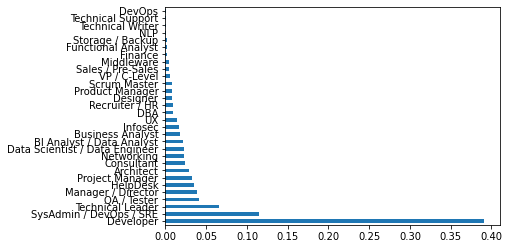

<IPython.core.display.Javascript object>

In [21]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)

df[:30].plot.barh()
charts["roles_percent"] = to_rechart(df, 30)

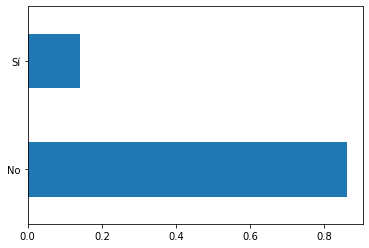

<IPython.core.display.Javascript object>

In [22]:
df = dataframe["contribuis_a_proyectos_open_source"].value_counts(
    normalize=True, sort=True
)

df.plot.barh()
charts["opensource_percent"] = to_rechart(df)

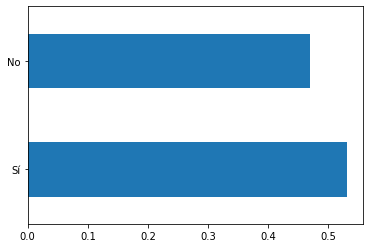

<IPython.core.display.Javascript object>

In [23]:
df = dataframe["programas_como_hobbie"].value_counts(normalize=True, sort=True)

df.plot.barh()
charts["hobbie_percent"] = to_rechart(df)

#### 2.1.3. Experiencia

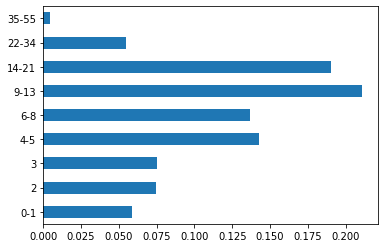

<IPython.core.display.Javascript object>

In [24]:
df = dataframe["anos_de_experiencia"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34", "35-55"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_percent"] = to_rechart(df.sort_index())

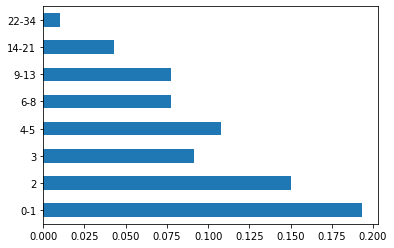

<IPython.core.display.Javascript object>

In [25]:
df = dataframe["anos_en_la_empresa_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_company"] = to_rechart(df.sort_index())

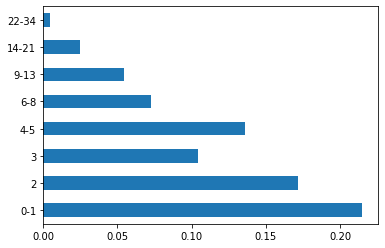

<IPython.core.display.Javascript object>

In [26]:
df = dataframe["anos_en_el_puesto_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_position"] = to_rechart(df.sort_index())

#### 2.1.4. Educación

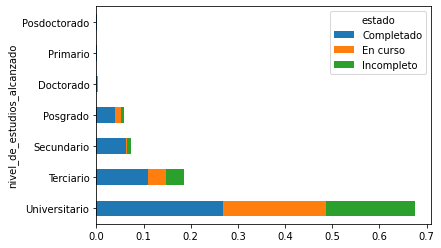

<IPython.core.display.Javascript object>

In [27]:
df = dataframe.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    dataframe
)

df.plot(kind="barh", stacked=True, logx=False)
charts["education_stacked"] = to_rechart(df)

29.48

Index(['Ingeniería en Sistemas de Información', 'Ingeniería en Informática',
       'Analista de Sistemas', 'Licenciatura en Sistemas de Información',
       'Licenciatura en Ciencias de la Computación',
       'Licenciatura en Informática', 'Tecnicatura en Programación',
       'Ingeniería Electrónica', 'Ingeniería en Computación',
       'Tecnicatura Superior en Programación', 'Diseño Gráfico',
       'Licenciatura en Análisis de Sistemas', 'Tecnicatura en Informática',
       'Licenciatura en Administración de Empresas', 'Analista Programador',
       'Ingeniería en Telecomunicaciones',
       'Analista Programador Universitario',
       'Tecnicatura Superior en Sistemas Informáticos', 'Telecomunicaciones',
       'Analista de Computación', 'Ingeniería en Software',
       'Analista Universitario de Sistemas', 'Diseño Multimedial',
       'Tecnicatura Superior en Análisis de Sistemas', 'Ingeniería Industrial',
       'Licenciatura en Psicología', 'Tecnicatura en Computación',
      

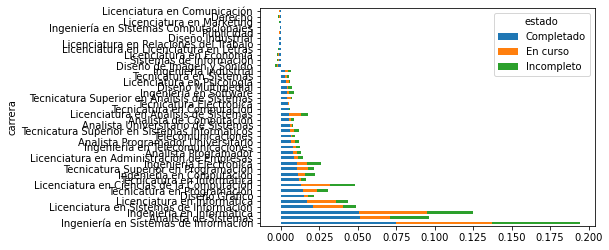

<IPython.core.display.Javascript object>

In [28]:
# Para el grado de completitud por carrera se tendrá en cuenta el tamaño de la muestra, se considerarán insuficientes los datos de aquellas carreras que representen menos del 0.5% del total

df = (
    dataframe["carrera"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("carrera > 0.005")
)

display(len(dataframe["carrera"]) * 0.005)
chosen_careers = df.index
display(chosen_careers)

df = dataframe.query('carrera != "DELETEME"')["carrera"].value_counts(
    normalize=True, sort=True
)
charts["careeres_percent"] = to_rechart(df, 40)

df = dataframe.query('carrera != "DELETEME"').groupby(["carrera", "estado"])[
    "carrera"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df.loc[
    df.eval("carrera not in @chosen_careers"), ["Completado", "En curso", "Incompleto"]
] *= -1

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["careeres_stacked_percent"] = to_rechart(df[:40])

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


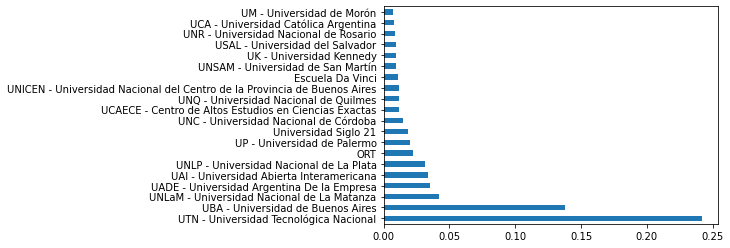

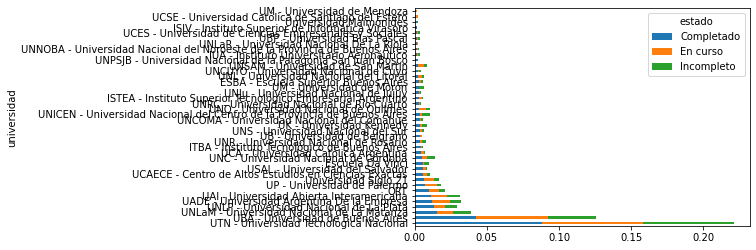

<IPython.core.display.Javascript object>

In [29]:
df = dataframe.query('universidad != "DELETEME"')["universidad"].value_counts(
    normalize=True, sort=True
)

df[:20].plot(kind="barh")
charts["universities_percent"] = to_rechart(df, 40)

df = dataframe.query('universidad != "DELETEME"').groupby(["universidad", "estado"])[
    "universidad"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["universities_stacked_percent"] = to_rechart(df, 40)

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


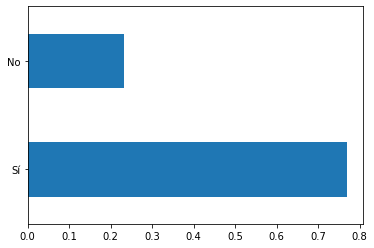

<IPython.core.display.Javascript object>

In [30]:
mask = dataframe["realizaste_cursos_de_especializacion"].str.contains("Sí")
dataframe.loc[mask, "hizo_curso"] = "Sí"
dataframe.loc[~mask, "hizo_curso"] = "No"

df = dataframe["hizo_curso"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_percent"] = to_rechart(df)

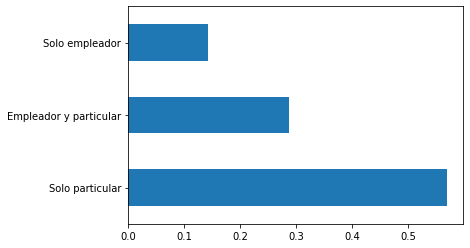

<IPython.core.display.Javascript object>

In [31]:
mask_empleador = dataframe["realizaste_cursos_de_especializacion"].str.contains(
    "un empleador"
)
mask_particular = dataframe["realizaste_cursos_de_especializacion"].str.contains(
    "de forma particular"
)

dataframe.loc[mask_particular, "quien_paga"] = "Solo particular"
dataframe.loc[mask_empleador, "quien_paga"] = "Solo empleador"
dataframe.loc[mask_empleador & mask_particular, "quien_paga"] = "Empleador y particular"

df = dataframe["quien_paga"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_pays_percent"] = to_rechart(df)

#### 2.1.5. Demografía

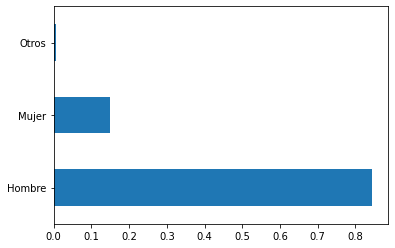

<IPython.core.display.Javascript object>

In [32]:
df = dataframe["me_identifico"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["demographics_gender_percent"] = to_rechart(df)

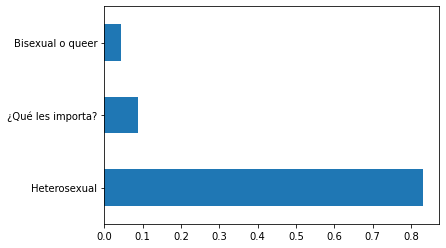

<IPython.core.display.Javascript object>

In [33]:
df = dataframe["orientacion_sexual"].value_counts(normalize=True, sort=True)

df[:3].plot(kind="barh")
charts["demographics_sexual_orientation_percent"] = to_rechart(df, 3)

### 2.2. Salarios

#### 2.2.1. Progresión Histórica

https://github.com/openqube/openqube-sueldos/blob/release/2020.02/pipeline/historical-data-analysis.ipynb

#### 2.2.2. Región

In [34]:
# Para el análisis regional se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas regiones que representen menos del 0.5% del total

df = (
    dataframe["donde_estas_trabajando"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("donde_estas_trabajando > 0.005")
)

display(len(dataframe["donde_estas_trabajando"]) * 0.005)
chosen_regions = df.index
display(chosen_regions)

29.48

Index(['Ciudad Autónoma de Buenos Aires', 'Buenos Aires', 'Córdoba',
       'Santa Fe', 'Mendoza', 'Entre Ríos', 'Río Negro', 'Neuquén', 'Jujuy',
       'Tucumán'],
      dtype='object')

<IPython.core.display.Javascript object>

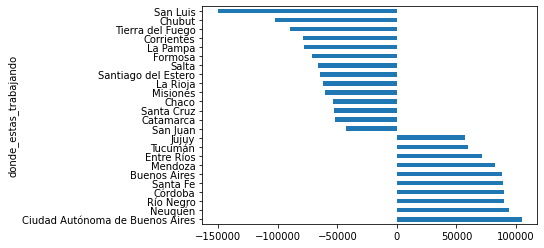

<IPython.core.display.Javascript object>

In [35]:
# Éstas serán convertidas a valores negativos, de manera de poder distinguirlas sin perjudicar a quienes deseen
# observar los resultados más allá del tamaño muestral acotado

df = dataframe.copy()

df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "salario_mensual_bruto_en_tu_moneda_local",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_median"] = to_rechart(df)

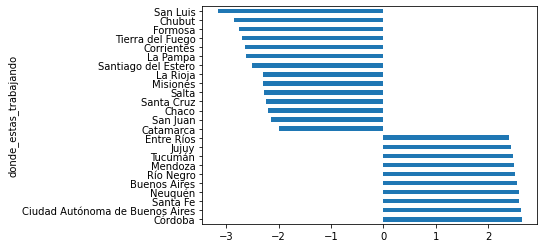

<IPython.core.display.Javascript object>

In [36]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "que_tan_conforme_estas_con_tu_sueldo",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .mean()
    .unstack()["que_tan_conforme_estas_con_tu_sueldo"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_acquiescence"] = to_rechart(df)

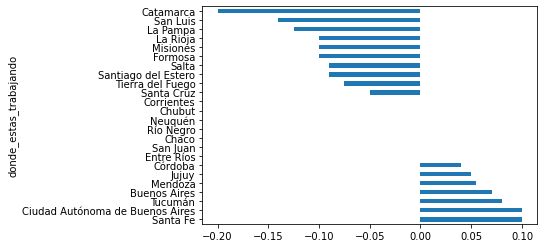

<IPython.core.display.Javascript object>

In [37]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "de_que_fue_el_ajuste_total",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["regions_salary_adjustment"] = to_rechart(df)

##### 2.2.2.1. Región (mínimos por seniority) - no incluídos en el reporte

In [38]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_bruto_en_tu_moneda_local"
    ]
    .min()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Neuquén,47945,22000,50000
Entre Ríos,21100,21300,35000
Río Negro,44500,47271,35000
Mendoza,25300,17650,30000
Jujuy,12000,36000,26000
Santa Fe,20000,18000,18000
Córdoba,15000,35000,17000
Ciudad Autónoma de Buenos Aires,11000,9500,12000
Tucumán,15000,40000,10723


<IPython.core.display.Javascript object>

##### 2.2.2.2. Región (máximos por seniority) - no incluídos en el reporte

In [39]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_bruto_en_tu_moneda_local"
    ]
    .max()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Ciudad Autónoma de Buenos Aires,350000,450000,460000
Buenos Aires,340000,430000,455000
Córdoba,320000,380000,450000
Santa Fe,126500,320000,450000
Mendoza,99000,160000,437500
Río Negro,56000,440000,400000
Entre Ríos,190000,118000,320000
Jujuy,52000,100000,300000
Neuquén,50512,145000,200000


<IPython.core.display.Javascript object>

#### 2.2.3. Puesto

##### 2.2.3.1. Seniority

29.48

Index(['Developer', 'SysAdmin / DevOps / SRE', 'Technical Leader',
       'QA / Tester', 'Manager / Director', 'HelpDesk', 'Project Manager',
       'Architect', 'Consultant', 'Networking',
       'Data Scientist / Data Engineer', 'BI Analyst / Data Analyst',
       'Business Analyst', 'Infosec', 'UX', 'DBA', 'Recruiter / HR',
       'Designer', 'Product Manager', 'Scrum Master', 'VP / C-Level'],
      dtype='object')

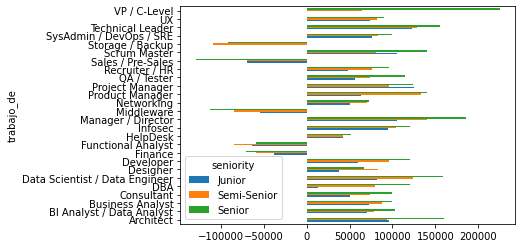

<IPython.core.display.Javascript object>

In [40]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total

df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

display(len(dataframe["trabajo_de"]) * 0.005)
chosen_roles = df.index
display(chosen_roles)


df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

df.plot(kind="barh")
charts["roles_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.3.1. Industria

29.48

Index(['Developer', 'SysAdmin / DevOps / SRE', 'Technical Leader',
       'QA / Tester', 'Manager / Director', 'HelpDesk', 'Project Manager',
       'Architect', 'Consultant', 'Networking',
       'Data Scientist / Data Engineer', 'BI Analyst / Data Analyst',
       'Business Analyst', 'Infosec', 'UX', 'DBA', 'Recruiter / HR',
       'Designer', 'Product Manager', 'Scrum Master', 'VP / C-Level'],
      dtype='object')

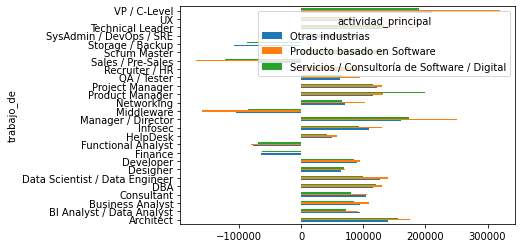

<IPython.core.display.Javascript object>

In [41]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

display(len(dataframe["trabajo_de"]) * 0.005)
chosen_roles = df.index
display(chosen_roles)


df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "actividad_principal"])
    .median()
    .unstack("actividad_principal")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"),
    [
        "Otras industrias",
        "Producto basado en Software",
        "Servicios / Consultoría de Software / Digital",
    ],
] *= -1

df.plot(kind="barh")
charts["roles_actividad_principal_salary_median"] = to_rechart(df[:30])

In [42]:
df.head()

actividad_principal,Otras industrias,Producto basado en Software,Servicios / Consultoría de Software / Digital
trabajo_de,,,
Architect,140000.0,175000.0,156667.0
BI Analyst / Data Analyst,95000.0,92000.0,72000.0
Business Analyst,95000.0,110000.0,85000.0
Consultant,103900.0,105760.0,80000.0
DBA,115000.0,130000.0,120000.0


<IPython.core.display.Javascript object>

##### 2.2.3.3. Seniority e Industria

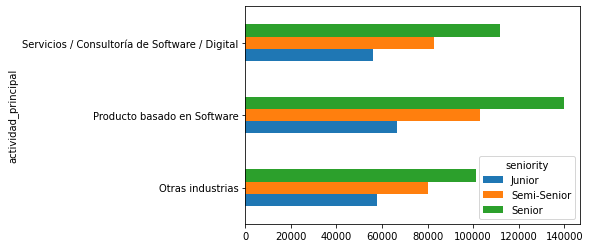

<IPython.core.display.Javascript object>

In [43]:
df = (
    dataframe.groupby(["actividad_principal", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
)  # .sort_values(by=[''],ascending=False)

df.plot.barh()
charts["actividad_principal_seniority_salary_median"] = to_rechart(df)

##### 2.2.3.2. Open source / hobbie

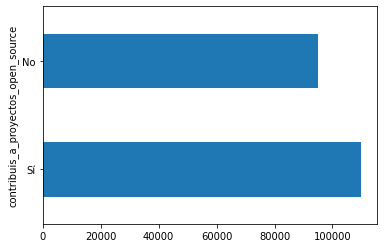

<IPython.core.display.Javascript object>

In [44]:
df = (
    dataframe.groupby(["contribuis_a_proyectos_open_source"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["opensource_salary_median"] = to_rechart(df)

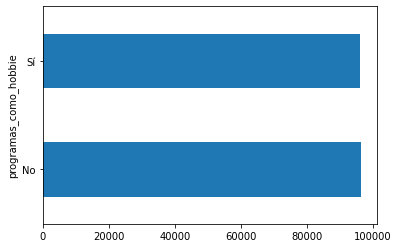

<IPython.core.display.Javascript object>

In [45]:
df = (
    dataframe.groupby(["programas_como_hobbie"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot.barh()
charts["hobbie_salary_median"] = to_rechart(df)

#### 2.2.4. Carrera

In [46]:
df = dataframe.groupby(["carrera", "estado"])["carrera"].count().unstack(
    "estado"
).fillna(0).sort_values(by=["Completado", "En curso"], ascending=False) / len(dataframe)

top_careers = df[:30].index

# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = df[:30]["Completado"].to_frame().query("Completado > 0.005")
display(df)
chosen_careers = df.index

,Completado
carrera,
Ingeniería en Sistemas de Información,0.074966
Analista de Sistemas,0.051221
Ingeniería en Informática,0.050543
Licenciatura en Sistemas de Información,0.020862
Licenciatura en Informática,0.016791
Diseño Gráfico,0.015095
Tecnicatura en Programación,0.014417
Licenciatura en Ciencias de la Computación,0.013229
Tecnicatura en Informática,0.012042


<IPython.core.display.Javascript object>

##### 2.2.4.1. Según Seniority

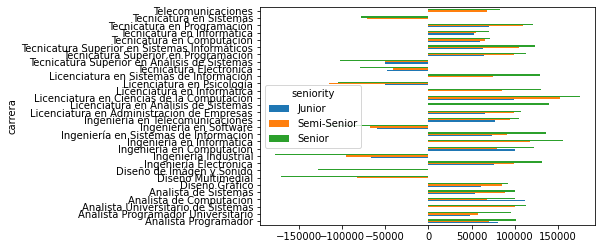

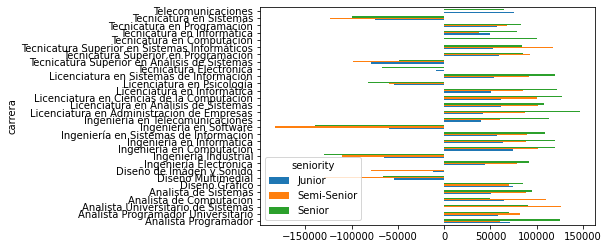

<IPython.core.display.Javascript object>

In [47]:
df = dataframe.query('estado == "Completado"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median"] = to_rechart(df[:30])


df = dataframe.query('estado == "En curso"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median_encurso"] = to_rechart(df[:30])

In [48]:
# Cuántos Ingenieros Industriales hay en el resultado obtenido, ya que sobresale del resto
df = dataframe.query('carrera in ["Ingeniería Industrial"] & estado == "Completado"')[
    ["seniority", "trabajo_de", "salario_mensual_bruto_en_tu_moneda_local"]
].sort_values(by=["salario_mensual_bruto_en_tu_moneda_local"], ascending=False)

display("Un {:.2f}%".format(len(df) / len(dataframe) * 100))
display(df)

'Un 0.27%'

,seniority,trabajo_de,salario_mensual_bruto_en_tu_moneda_local
1353,Semi-Senior,Manager / Director,400000
4741,Senior,Sales / Pre-Sales,270000
48,Senior,Product Manager,235500
732,Senior,Data Scientist / Data Engineer,235000
1649,Senior,Architect,177000
2324,Junior,BI Analyst / Data Analyst,167000
5644,Senior,BI Analyst / Data Analyst,165000
328,Senior,Developer,145000
5846,Semi-Senior,Data Scientist / Data Engineer,100000
4570,Semi-Senior,Business Analyst,95600


<IPython.core.display.Javascript object>

##### 2.2.4.2. Según Estado de la Carrera

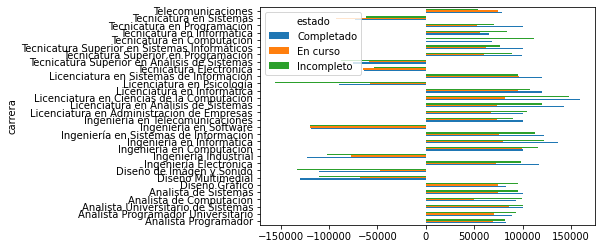

<IPython.core.display.Javascript object>

In [49]:
df = dataframe.copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "estado"], "salario_mensual_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_estado_salary_median"] = to_rechart(df[:30])

##### 2.2.4.3. Según Nivel de Estudios Alcanzado

29.48

Index(['Universitario', 'Terciario', 'Secundario', 'Posgrado'], dtype='object')

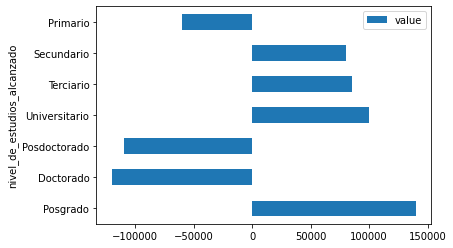

<IPython.core.display.Javascript object>

In [50]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["nivel_de_estudios_alcanzado"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("nivel_de_estudios_alcanzado > 0.005")
)

display(len(dataframe["nivel_de_estudios_alcanzado"]) * 0.005)
chosen_levels = df.index
display(chosen_levels)

df = (
    dataframe.groupby(["nivel_de_estudios_alcanzado"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
    .to_frame("value")
)
df.loc[df.eval("nivel_de_estudios_alcanzado not in @chosen_levels"), "value"] *= -1

df.plot(kind="barh")
charts["nivel_estudios_salary_median"] = to_rechart(df)

##### 2.2.4.4. Según hicieron o no Cursos de Especialización

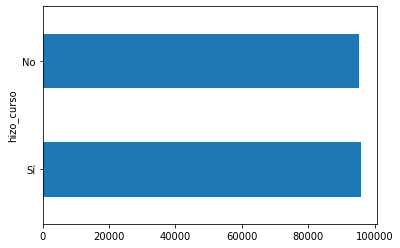

<IPython.core.display.Javascript object>

In [51]:
df = (
    dataframe.groupby(["hizo_curso"])
    .median()
    .unstack()["salario_mensual_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["hizo_curso_salary_median"] = to_rechart(df)

#### 2.2.5. Tecnología

##### 2.2.5.1. Según Plataformas

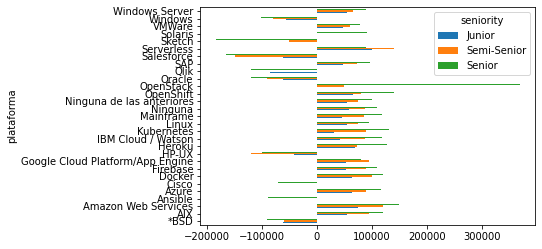

<IPython.core.display.Javascript object>

In [52]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)
top_platforms = df[:30].index

chosen_platforms = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["plataformas"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["plataformas"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_bruto_en_tu_moneda_local"],
        value_name="plataforma",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("plataforma in @top_platforms")
    .groupby(["plataforma", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("plataforma not in @chosen_platforms"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

df[:30].plot(kind="barh")
charts["plataformas_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.5.2. Según Lenguajes de Programación

seniority,Junior,Semi-Senior,Senior
lenguaje_de_programacion,,,
.NET,57634.0,85000.0,120000.0
ABAP,-49475.0,-90000.0,-100000.0
ActionScript,-48000.0,-60000.0,-115000.0
Bash/Shell,67500.0,95750.0,123828.0
C,46724.0,74000.0,120000.0
C#,48850.0,69800.0,106500.0
C++,40000.0,86000.0,85000.0
COBOL,-48600.0,-104500.0,-140000.0
CSS,60000.0,90000.0,117000.0


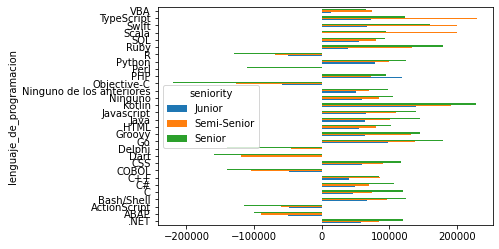

<IPython.core.display.Javascript object>

In [53]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["lenguajes_de_programacion"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)
top_languages = df[:30].index

chosen_languages = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["lenguajes_de_programacion"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["lenguajes_de_programacion"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_bruto_en_tu_moneda_local"],
        value_name="lenguaje_de_programacion",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("lenguaje_de_programacion in @top_languages")
    .groupby(["lenguaje_de_programacion", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("lenguaje_de_programacion not in @chosen_languages"),
    ["Junior", "Semi-Senior", "Senior"],
] *= -1

display(df)
df.plot(kind="barh")
charts["lenguajes_de_programacion_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.6. Otras compensaciones

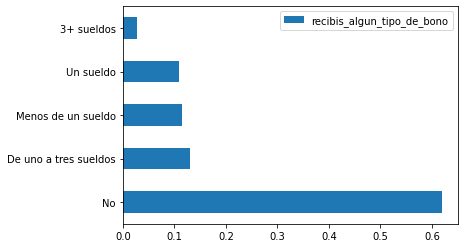

<IPython.core.display.Javascript object>

In [54]:
df = (
    dataframe["recibis_algun_tipo_de_bono"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["bonos_percent"] = to_rechart(df)

#### 2.2.6. Tipo de contrato

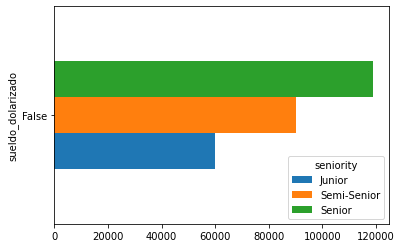

<IPython.core.display.Javascript object>

In [55]:
df = (
    dataframe.groupby(["sueldo_dolarizado", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)
df.plot(kind="barh")
charts["sueldo_dolarizado_salary_median"] = to_rechart(df)

### 2.3. Género

#### 2.3.1. Progresión Histórica

#### 2.3.2. Preparación

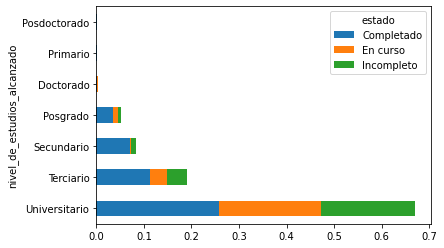

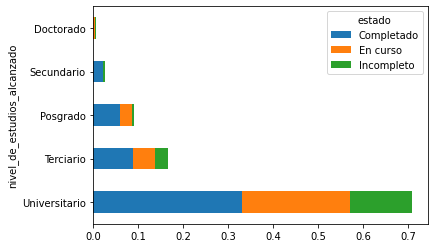

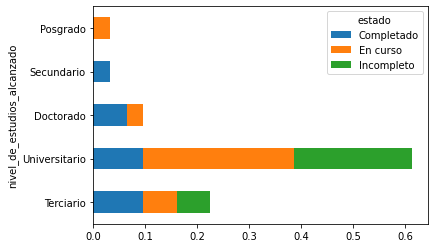

<IPython.core.display.Javascript object>

In [56]:
df = dataframe.query('me_identifico == "Hombre"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_hombre_stacked"] = to_rechart(df)

df = dataframe.query('me_identifico == "Mujer"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_mujer_stacked"] = to_rechart(df)

df = dataframe.query('me_identifico == "Otros"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_otros_stacked"] = to_rechart(df)

#### 2.3.3. Salarios

In [57]:
# df = dataframe['trabajo_de'].value_counts(normalize=True, sort=True)
# top_roles = df[:26].index

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Junior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_junior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Semi-Senior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_semisenior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

# df = dataframe.query('(trabajo_de in @top_roles) & (seniority == "Senior")')
# df = df.groupby(['trabajo_de', 'me_identifico']).median().unstack('me_identifico')['salario_mensual_bruto_en_tu_moneda_local'].fillna(0)
# df.loc[ df.eval('trabajo_de not in @chosen_roles'), ['Hombre', 'Mujer', 'Otros']] *= -1
# charts['roles_seniority_salary_senior_median'] = to_rechart(df, 30)
# df.plot(kind='barh')

<IPython.core.display.Javascript object>

In [58]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

top_salary_roles = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de"])
    .median()["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)
top_salary_roles_mujer = (
    dataframe.query('trabajo_de in @top_roles & me_identifico == "Mujer"')
    .groupby(["trabajo_de"])
    .median()["salario_mensual_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)

# Roles mejores pagos en los que no se encuentran mujeres
display([rol for rol in top_salary_roles if rol not in top_salary_roles_mujer])

['Storage / Backup']

<IPython.core.display.Javascript object>

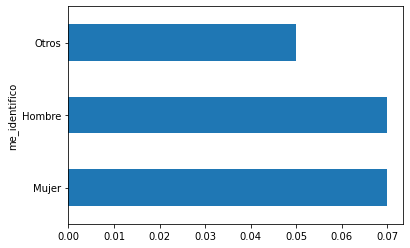

<IPython.core.display.Javascript object>

In [59]:
df = (
    dataframe.groupby(["me_identifico"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["gender_salary_adjustment"] = to_rechart(df)

#### 2.3.4. Experiencia

me_identifico,Hombre,Mujer,Otros
actividad_principal,,,
Otras industrias,0.858702,0.136703,0.004595
Producto basado en Software,0.843043,0.150217,0.006740
Servicios / Consultoría de Software / Digital,0.835419,0.160250,0.004331


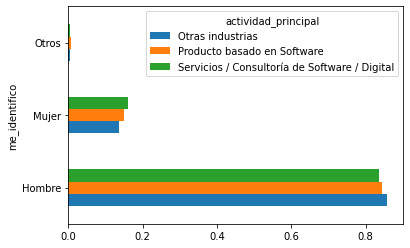

<IPython.core.display.Javascript object>

In [60]:
df = dataframe
df = (
    df.groupby(["actividad_principal", "me_identifico"])
    .agg({"me_identifico": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_identifico")
)
df.columns = df.columns.droplevel(0)
display(df)
df.T.plot(kind="barh")
charts["actividad_principal_gender_percent"] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
0-1,0.794798,0.199422,0.005780
2,0.784580,0.206349,0.009070
3,0.817568,0.175676,0.006757
4-5,0.844048,0.150000,0.005952
6-8,0.838910,0.157373,0.003717
9-13,0.861625,0.135961,0.002414
14-21,0.895536,0.100000,0.004464
22-55,0.903134,0.088319,0.008547


/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


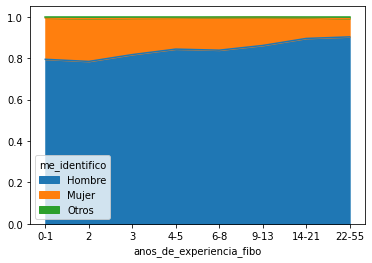

<IPython.core.display.Javascript object>

In [61]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"me_identifico": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="area")
charts["experience_gender_percent"] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
0-1,53000,52200,54500
2,70000,65000,93500
3,80000,83000,55000
4-5,96500,88750,102500
6-8,105000,95800,150000
9-13,117900,112000,93000
14-21,130000,107500,250000
22-55,120000,92914,98000


/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


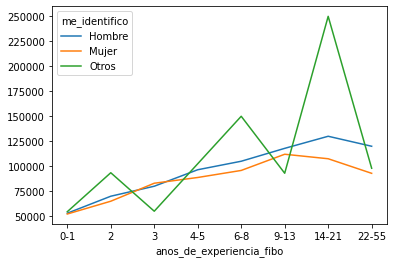

<IPython.core.display.Javascript object>

In [62]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"salario_mensual_bruto_en_tu_moneda_local": "median"})
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_salary_median"] = to_rechart(df)

me_identifico,Hombre,Mujer,Otros
anos_de_experiencia_fibo,,,
0-1,2.578182,2.579710,3.000000
2,2.523121,2.670330,2.750000
3,2.564738,2.730769,2.666667
4-5,2.602257,2.611111,2.200000
6-8,2.651403,2.574803,3.333333
9-13,2.667600,2.674556,1.666667
14-21,2.616152,2.500000,2.400000
22-55,2.498423,2.387097,2.666667


/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


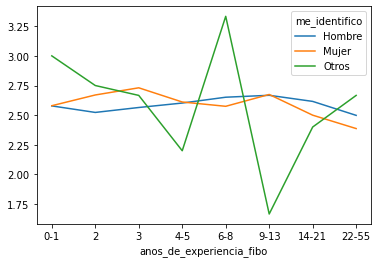

<IPython.core.display.Javascript object>

In [63]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"que_tan_conforme_estas_con_tu_sueldo": "mean"})
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_conformidad_mean"] = to_rechart(df)

#### 2.3.5. Discapacidad

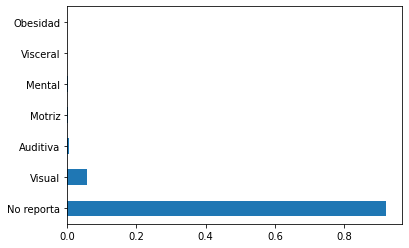

<IPython.core.display.Javascript object>

In [64]:
df = dataframe["tenes_algun_tipo_de_discapacidad"].fillna("No reporta").value_counts(
    normalize=False, sort=True
) / len(dataframe)

# df = dataframe['tenes_algun_tipo_de_discapacidad'].value_counts(normalize=True, sort=True)#.to_frame()

df[:7].plot(kind="barh")
charts["discapacidad_percent"] = to_rechart(df, 7)

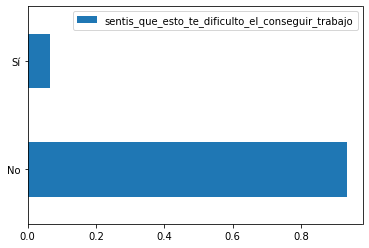

<IPython.core.display.Javascript object>

In [65]:
# Quienes respondieron Sí o No, son quienes contestaron sobre discapacidad.  El resto es None
df = (
    dataframe["sentis_que_esto_te_dificulto_el_conseguir_trabajo"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["discapacidad_dificultad_percent"] = to_rechart(df)

### 2.4. Tecnología

#### 2.4.1. Plataformas más populares

'reduced in 0.025714'

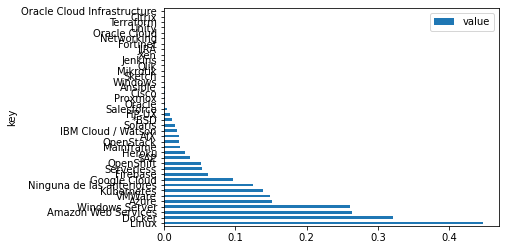

<IPython.core.display.Javascript object>

In [66]:
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "Google Cloud Platform/App Engine": "Google Cloud",
        "Sap": "SAP",
        "crm": "CRM",
        "^(nada|no|ningun[ao]|otros?|0|-|.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:40].plot.barh()
charts["plataformas"] = to_rechart(df[:40])

#### 2.4.2. Lenguajes de Programación más populares

'reduced in 0.061224'

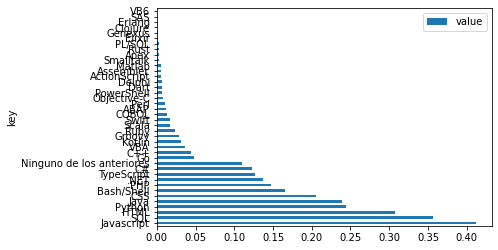

<IPython.core.display.Javascript object>

In [67]:
df = (
    dataframe["lenguajes_de_programacion"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "powershell": "PowerShell",
        "cobol": "COBOL",
        "^(nada|no|ningun[ao]|otros?|-|.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:40].plot.barh()
charts["lenguajes_de_programacion"] = to_rechart(df[:40])

#### 2.4.3. Frameworks, Herramientas y Librerías más populares

'reduced in 0.047091'

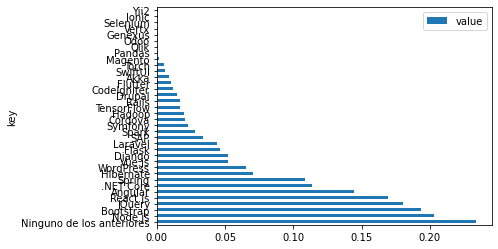

<IPython.core.display.Javascript object>

In [68]:
df = (
    dataframe["frameworksherramientas_y_librerias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(node).*$": "Node.js",
        ".*Angular.*$": "Angular",
        ".*React.*$": "React.js",
        ".*Vue.*$": "Vue.js",
        ".*jquery.*$": "jQuery",
        ".*laravel.*$": "Laravel",
        ".*codeigniter.*$": "CodeIgniter",
        ".*struts.*$": "Struts",
        "^(nada|no|ningun[ao]|otros?|0|-|.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:36].plot.barh()
charts["frameworksherramientas_y_librerias"] = to_rechart(df[:36])

#### 2.4.4. Bases de Datos más populares

'reduced in 0.040816'

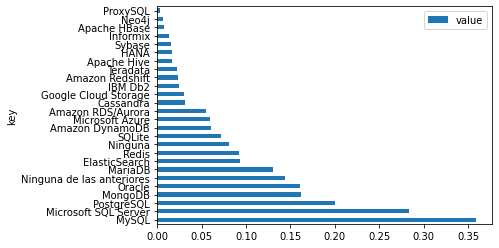

<IPython.core.display.Javascript object>

In [69]:
df = (
    dataframe["bases_de_datos"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(sybase).*$": "Sybase",
        "Microsoft Azure \(Tables": "Microsoft Azure",
        "^(SQL|CosmosDB|etc\)|otros?|0|-|.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["bases_de_datos"] = to_rechart(df[:26])

#### 2.4.5. Herramientas de QA / Testing más populares

'reduced in 0.986547'

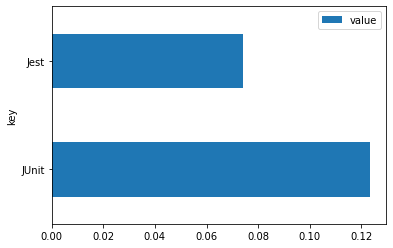

<IPython.core.display.Javascript object>

In [70]:
df = (
    dataframe["qa_testing"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(ningun[oa]|no|nada|otros?|0|.).*$": "DELETEME",
        ".*(junit).*$": "JUnit",
        ".*(jest).*$": "Jest",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:25].plot.barh()
charts["qa_testing"] = to_rechart(df[:25])

#### 2.4.6. IDEs más populares

'reduced in 0.125000'

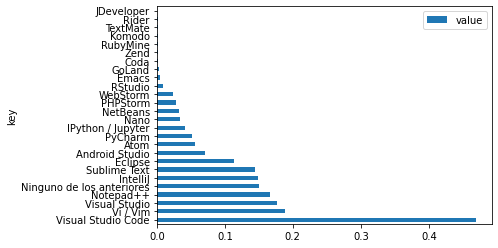

<IPython.core.display.Javascript object>

In [71]:
df = (
    dataframe["ides"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "^.*(Visual Studio|VS).*$": "Visual Studio",
        "^.*(Visual Studio Code|VS ?Code|Code).*$": "Visual Studio Code",
        ".*(Sublime)( Text)?.*$": "Sublime Text",
        ".*(webstorm).*$": "WebStorm",
        "^(vi|vim)$": "Vi / Vim",
        "^(jdeveloper)$": "JDeveloper",
        "^(goland)$": "GoLand",
        "^(neovim)$": "NeoVim",
        "IBM integración toolkit": "IBM Integration Bus",
        "^(rubymine)$": "RubyMine",
        "^(no( uso.*| util.*)?|none|ningun[ao]|0|No s[eé]|nada|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["ides"] = to_rechart(df[:26])

### 2.5. Trabajo

#### 2.5.1. Tipos de contrato

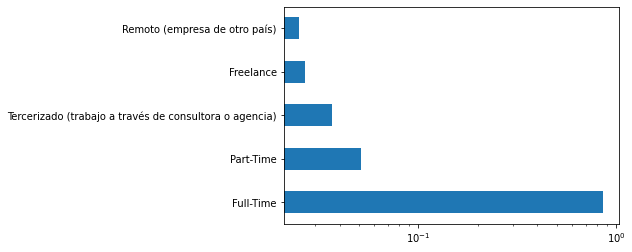

<IPython.core.display.Javascript object>

In [72]:
df = dataframe["tipo_de_contrato"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["tipo_de_contrato_percent"] = to_rechart(df)

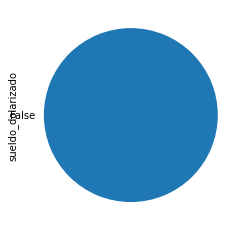

<IPython.core.display.Javascript object>

In [73]:
df = dataframe["sueldo_dolarizado"].value_counts(normalize=True, sort=True)
df.plot.pie()
charts["sueldo_dolarizado_percent"] = to_rechart(df)

#### 2.5.2. Compensación

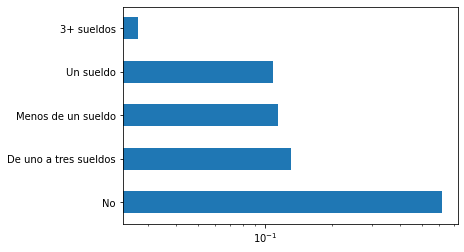

<IPython.core.display.Javascript object>

In [74]:
df = dataframe["recibis_algun_tipo_de_bono"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["recibis_algun_tipo_de_bono"] = to_rechart(df)

'reduced in 0.190616'

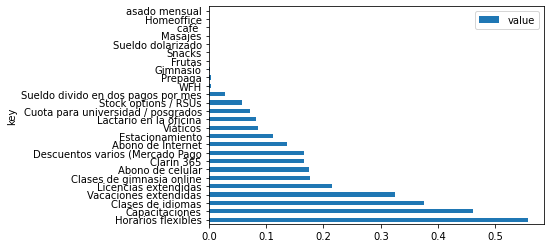

<IPython.core.display.Javascript object>

In [75]:
df = (
    dataframe["beneficios_extra"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*Vacaciones flexibles.*$": "Vacaciones extendidas",
        ".*Licencias?.*$": "Licencias extendidas",
        "horarios? flexibles?$": "Horarios flexibles",
        "(.*capacitaci[oó]n(es)?.*|.*cursos?.*)$": "Capacitaciones",
        "bebidas?$": "Bebidas",
        "(golosinas?|snac?ks?)$": "Snacks",
        "(Descuentos varios \(Clarín 365)$": "Descuentos varios",
        "(etc\)|Club La Nación)$": "DELETEME",
        "(no|.*Nada.*|Ning[uú]n[ao]?( de las anteriores)?)$": "DELETEME",
        "(.*prepaga.*|OSDE|.*obra social.*)$": "Prepaga",
        "(frut[ao]s?)$": "Frutas",
        "(facturas?)": "Facturas",
        "(.*home off?ice.*|.*WFH.*|.*home work.*)$": "WFH",
        "(.*d[oó]lares.*|Sueldo dolarizado)$": "Sueldo dolarizado",
        "(.*gimnasio.*|.*gym.*)$": "Gimnasio",
        "(.*cochera.*|.*estacionamiento.*)$": "Estacionamiento",
        "(.*combustibles?.*|.*vi[aá]ticos?.*|.*cabify.*|.*transporte.*|.*remis.*)$": "Viáticos",
        "(.*sueldos? ex.*)$": "Sueldos extra",
        "(.*eventos?.*|entradas?)$": "Eventos",
        "(.*pileta)$": "Pileta",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["beneficios_extra"] = to_rechart(df[:26])

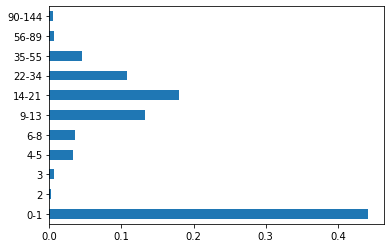

<IPython.core.display.Javascript object>

In [76]:
df = dataframe["de_que_fue_el_ajuste_total"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144],
        labels=[
            "0-1",
            "2",
            "3",
            "4-5",
            "6-8",
            "9-13",
            "14-21",
            "22-34",
            "35-55",
            "56-89",
            "90-144",
        ],
        include_lowest=True,
    )
).count() / len(df)

df.plot.barh()
charts["de_que_fue_el_ajuste"] = to_rechart(df.sort_index())

#### 2.5.3. Características de la Empresa

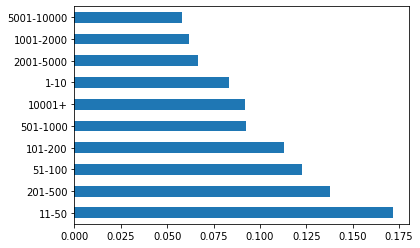

<IPython.core.display.Javascript object>

In [77]:
df = dataframe["cantidad_de_empleados"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["cantidad_de_empleados"] = to_rechart(df)

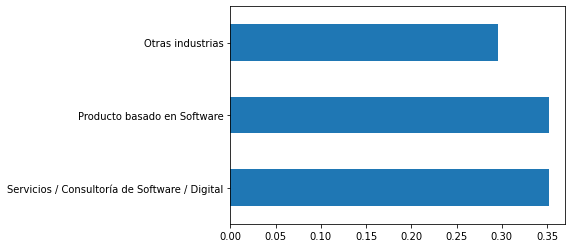

<IPython.core.display.Javascript object>

In [78]:
df = dataframe["actividad_principal"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["actividad_principal"] = to_rechart(df)

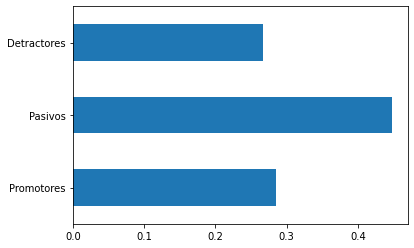

<IPython.core.display.Javascript object>

In [79]:
df = dataframe["la_recomendas_como_un_buen_lugar_para_trabajar"].copy()
# https://es.wikipedia.org/wiki/Net_Promoter_Score
df = df.groupby(
    pd.cut(df.values, [0, 6, 8, 10], labels=["Detractores", "Pasivos", "Promotores"])
).count() / len(df)
df = df.iloc[::-1]  # reverse order

df.plot.barh()
charts["la_recomendas_como_un_buen_lugar_para_trabajar"] = to_rechart(df)

'reduced in 0.109388'

,value
key,
MercadoLibre,0.121099
Globant,0.034091
Medallia,0.032564
MuleSoft,0.020862
Santander,0.011703
Accenture,0.011194
Google,0.010176
Auth0,0.008480
ASAPP,0.008311


<AxesSubplot:ylabel='key'>

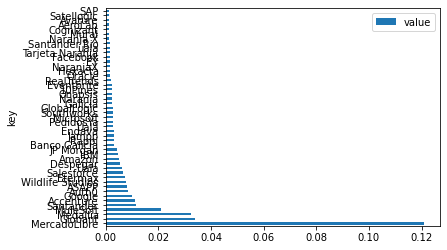

<IPython.core.display.Javascript object>

In [80]:
df = (
    dataframe[
        "cuales_consideras_que_son_las_mejores_empresas_de_it_para_trabajar_en_este_momentoen_tu_ciudad"
    ]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "^(ningun[ao]|-|no lo se|desconozco|ni idea|no s[ée]|Son todas una mierda\.|bancos?)$": "DELETEME",
        "^(mercadolibre|mercado libre|meli|ml|mercado ?pago)$": "MercadoLibre",
        "^(medallia|medalia)$": "Medallia",
        "^(despegar\.?(com)?)$": "Despegar",
        "^(mulesoft)$": "Mulesoft",
        "^(globant)$": "Globant",
        "^(google)$": "Google",
        "^(auth0)$": "Auth0",
        "^(rappi)$": "Rappi",
        "^(jampp?)$": "Jampp",
        "^(asapp|asap)$": "ASAPP",
        "^(ibm|i\.b\.m\.?)$": "IBM",
        "^(aws|amazon)$": "Amazon",
        "^(eventbrite)$": "Eventbrite",
        "^(saleforce|salesforce)$": "Salesforce",
        "^(olx|o\.l\.x\.?)$": "OLX",
        "^(10 ?pines)$": "10Pines",
        "^(microsoft)$": "Microsoft",
        "^(jp ?morgan)$": "JP Morgan",
        "^(elementum)$": "Elementum",
        "^(bell?atrix)$": "Belatrix",
        "^(nubank)$": "Nubank",
        "^(etermax)$": "Etermax",
        "^(facebook)$": "Facebook",
        "^(hexacta)$": "Hexacta",
        "^(oracle)$": "Oracle",
        "^(avature)$": "Avature",
        "^(everis)$": "Everis",
        "^(baires ?dev)$": "NubaBairesDevnk",
        "^(stensul)$": "Stensul",
        "^(satel? ?logic\.?)$": "Satellogic",
        "^(scale)$": "Scale",
        "^(aerolab)$": "AeroLab",
        "^(rga|r/ga)$": "R/GA",
        "^(accenture)$": "Accenture",
        "^(olapic)$": "Olapic",
        "^(logicalis)$": "Logicalis",
        "^(mule ?(soft)?)$": "MuleSoft",
        "^(soft ?vision)$": "SoftVision",
        "^(global ?logic)$": "GlobalLogic",
        "^(pedidos ?ya)$": "PedidosYa",
        "^(decentra ?land)$": "DecentraLand",
        "^(real ?trends)$": "RealTrends",
        "^(nubi ?lmetri(x|cs))$": "Nubimetrics",
        "^(santander( tec.*))$": "Santander",
        "^(wildlife|wildlife*)$": "Wildlife Studios",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)
display(df[:47])
df[:47].plot.barh()

## 3. Publicación

In [81]:
import json

# formateamos valores flotantes para ahorrar caracteres (#macritips)
display(
    json.dumps(
        json.loads(
            json.dumps(charts, allow_nan=False),
            parse_float=lambda x: round(float(x), 5),
        )
    )
)

'{"total_surveyed": 6415, "total_analyzed_surveyed": 5896, "regions_percent": {"data": [{"name": "Ciudad Aut\\u00f3noma de Buenos Aires", "value": 0.62301}, {"name": "Buenos Aires", "value": 0.16559}, {"name": "C\\u00f3rdoba", "value": 0.07222}, {"name": "Santa Fe", "value": 0.05858}, {"name": "Mendoza", "value": 0.01749}, {"name": "Entre R\\u00edos", "value": 0.00979}, {"name": "R\\u00edo Negro", "value": 0.00647}, {"name": "Neuqu\\u00e9n", "value": 0.00629}, {"name": "Jujuy", "value": 0.00595}, {"name": "Tucum\\u00e1n", "value": 0.00542}, {"name": "Chaco", "value": 0.0042}, {"name": "Misiones", "value": 0.00402}, {"name": "Chubut", "value": 0.0035}, {"name": "Corrientes", "value": 0.00297}, {"name": "Salta", "value": 0.00245}, {"name": "La Rioja", "value": 0.00227}, {"name": "San Luis", "value": 0.0021}, {"name": "Tierra del Fuego", "value": 0.00175}, {"name": "Santiago del Estero", "value": 0.0014}, {"name": "La Pampa", "value": 0.0014}, {"name": "San Juan", "value": 0.00122}, {"nam

<IPython.core.display.Javascript object>